# Ciencia De Datos Aplicada (ITBA): Segundo Entregable

## Recopilación y Preparación de Datos

**Equipo:** Uriel Arias - 63504, Cristian Tepedino - 62830

**Nombre del proyecto**: Sistema de predicción de resultados de carreras de Fórmula 1

### 🧾 1. Importación y carga de librerías

In [3]:
!pip install kagglehub
!pip install fastf1


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tabulate import tabulate
from scipy.stats import entropy

import fastf1

cache_dir = './cache'
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
sns.set_context("notebook", rc={"xtick.labelsize":10, "ytick.labelsize":10})


### 🧾 2. Carga de datos

In [2]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
files_to_load = [
    "races.csv",
    "results.csv",
    "qualifying.csv",
    "drivers.csv",
    "constructors.csv",
    "circuits.csv",
    "driver_standings.csv",
    "constructor_standings.csv"
]

dfs = {}
for fname in files_to_load:
    fpath = os.path.join(path, fname)
    if os.path.exists(fpath):
        dfs[fname.replace(".csv", "")] = pd.read_csv(fpath, na_values="\\N")
    else:
        print(f"⚠️ No encontrado: {fname}")

races = dfs["races"]
results = dfs["results"]
qualifying = dfs["qualifying"]
drivers = dfs["drivers"]
constructors = dfs["constructors"]
circuits = dfs["circuits"]
driver_standings = dfs["driver_standings"]
constructor_standings = dfs["constructor_standings"]

driver_standings = driver_standings.rename(columns={'points':'points_driver','wins':'wins_driver'})
constructor_standings = constructor_standings.rename(columns={'points':'points_constructor','wins':'wins_constructor'})

results.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1


### 🗒️ 3. Descripción del dataset

El dataset se obtuvo de Kaggle, mediante un dataset que recuperaba la información de carreras de Formula 1 de la API de Ergast (La cual ya no esta disponible actualmente). Se tiene información sobre carreras de Formula 1 desde 1950 hasta 2024

El dataset contiene los siguientes tipos de datos:

#### Drivers
| Campo         | Descripción                       |
| ------------- | --------------------------------- |
| `driverId`    | Identificador único del piloto    |
| `driverRef`   | Nombre corto o referencia interna |
| `number`      | Número de piloto (si disponible)  |
| `code`        | Código de 3 letras del piloto     |
| `forename`    | Nombre                            |
| `surname`     | Apellido                          |
| `dob`         | Fecha de nacimiento               |
| `nationality` | Nacionalidad del piloto           |

#### Constructors
| Campo            | Descripción                         |
| ---------------- | ----------------------------------- |
| `constructorId`  | Identificador único del constructor |
| `constructorRef` | Nombre corto o referencia interna   |
| `name`           | Nombre completo del equipo          |
| `nationality`    | Nacionalidad del equipo             |


#### Circuits
| Campo        | Descripción                                   |
| ------------ | --------------------------------------------- |
| `circuitId`  | Identificador único del circuito              |
| `circuitRef` | Nombre corto o referencia interna             |
| `name`       | Nombre completo del circuito                  |
| `location`   | Ciudad o región                               |
| `country`    | País donde se corre                           |
| `lat`        | Latitud                                       |
| `lng`        | Longitud                                      |
| `alt`        | Altitud                                       |
| `url`        | Página web del circuito (Wikipedia u oficial) |

#### Races
| Campo       | Descripción                       |
| ----------- | --------------------------------- |
| `raceId`    | Identificador único de la carrera |
| `year`      | Año de la temporada               |
| `round`     | Número de carrera en la temporada |
| `circuitId` | Circuito donde se corre (FK)      |
| `name`      | Nombre del GP                     |
| `date`      | Fecha de la carrera               |
| `time`      | Hora de inicio (si disponible)    |
| `url`       | Página web de referencia          |

#### Results

| Campo             | Descripción                                             |
| ----------------- | ------------------------------------------------------- |
| `resultId`        | Identificador único de la fila                          |
| `raceId`          | FK a `races`                                            |
| `driverId`        | FK a `drivers`                                          |
| `constructorId`   | FK a `constructors`                                     |
| `number`          | Número de coche                                         |
| `grid`            | Posición de largada                                     |
| `position`        | Posición final                                          |
| `positionText`    | Posición final en texto (ej: “R” = retirado)            |
| `positionOrder`   | Posición ajustada (para casos de descalificación, etc.) |
| `points`          | Puntos obtenidos                                        |
| `laps`            | Vueltas completadas                                     |
| `time`            | Tiempo total de carrera (string)                        |
| `milliseconds`    | Tiempo total en ms                                      |
| `fastestLap`      | Número de la vuelta más rápida                          |
| `rank`            | Ranking de la vuelta rápida                             |
| `fastestLapTime`  | Tiempo de la vuelta más rápida (string)                 |
| `fastestLapSpeed` | Velocidad promedio de la vuelta más rápida              |
| `statusId`        | Estado de finalización (retirado, terminado, etc.)      |

#### Qualifying

| Campo           | Descripción           |
| --------------- | --------------------- |
| `qualifyId`     | ID único              |
| `raceId`        | FK a `races`          |
| `driverId`      | FK a `drivers`        |
| `constructorId` | FK a `constructors`   |
| `number`        | Número de coche       |
| `position`      | Posición en la sesión |
| `q1`            | Tiempo en Q1          |
| `q2`            | Tiempo en Q2          |
| `q3`            | Tiempo en Q3          |

#### Driver Standings

| Campo           | Descripción                                                               |
| --------------- | ------------------------------------------------------------------------- |
| `raceId`        | FK a `races.csv`  |
| `driverId`      | FK a `drivers.csv`                      |
| `points`        | Puntos acumulados hasta esa carrera.                                      |
| `position`      | Posición en el campeonato tras esa carrera (1 = líder, 2 = segundo, etc.). |
| `positionText`  | Representación textual de la posición (puede incluir "=" para empate).    |
| `wins`          | Número de victorias acumuladas hasta esa carrera.                         |
| `constructorId` | FK a `constructors.csv`                    |


#### Constructor Standings

| Campo           | Descripción                                                         |
| --------------- | ------------------------------------------------------------------- |
| `raceId`        | FK a `races.csv` |
| `constructorId` | FK a `constructors.csv`                  |
| `points`        | Puntos acumulados hasta esa carrera.                                |
| `position`      | Posición en el campeonato de constructores tras esa carrera.        |
| `positionText`  | Representación textual de la posición.                              |
| `wins`          | Número de victorias del constructor acumuladas hasta esa carrera.   |


#### Variable objetivo

En este caso, nuestra variable objetivo es results.positionOrder. Podria codificarse como una variable discreta que clasifique si gana, si quedo en el podio, o si quedo fuera del podio


### 🔍 4. Análisis exploratorio de datos (EDA)

In [6]:
#Información general
races.info()
results.info()
qualifying.info()
drivers.info()
constructors.info()
circuits.info()
driver_standings.info()
constructor_standings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1125 non-null   int64 
 1   year         1125 non-null   int64 
 2   round        1125 non-null   int64 
 3   circuitId    1125 non-null   int64 
 4   name         1125 non-null   object
 5   date         1125 non-null   object
 6   time         394 non-null    object
 7   url          1125 non-null   object
 8   fp1_date     90 non-null     object
 9   fp1_time     68 non-null     object
 10  fp2_date     90 non-null     object
 11  fp2_time     68 non-null     object
 12  fp3_date     72 non-null     object
 13  fp3_time     53 non-null     object
 14  quali_date   90 non-null     object
 15  quali_time   68 non-null     object
 16  sprint_date  18 non-null     object
 17  sprint_time  15 non-null     object
dtypes: int64(4), object(14)
memory usage: 158.3+ KB
<class 'pandas.core.

In [7]:
#Información general
display(races.describe())
display(results.describe())
display(qualifying.describe())
display(drivers.describe())
display(constructors.describe())
display(circuits.describe())
display(driver_standings.describe())
display(constructor_standings.describe())

,raceId,year,round,circuitId
count,1125.000000,1125.000000,1125.000000,1125.000000
mean,565.710222,1992.703111,8.579556,23.889778
std,328.813817,20.603848,5.159910,19.633527
min,1.000000,1950.000000,1.000000,1.000000
25%,282.000000,1977.000000,4.000000,9.000000
50%,563.000000,1994.000000,8.000000,18.000000
75%,845.000000,2011.000000,13.000000,34.000000
max,1144.000000,2024.000000,24.000000,80.000000


,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,statusId
count,26759.000000,26759.000000,26759.000000,26759.000000,26753.000000,26759.000000,15806.000000,26759.000000,26759.000000,26759.000000,7.680000e+03,8252.000000,8510.000000,8252.000000,26759.000000
mean,13380.977391,551.687283,278.673530,50.180537,18.153927,11.134796,8.020499,12.794051,1.987632,46.301768,6.185833e+06,42.732913,10.334313,204.116330,17.224971
std,7726.134642,313.265036,282.703039,61.551498,15.581135,7.202860,4.840796,7.665951,4.351209,29.496557,1.669306e+06,16.603460,6.140957,21.377265,26.026104
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.260000e+02,1.000000,0.000000,89.540000,1.000000
25%,6690.500000,300.000000,57.000000,6.000000,7.000000,5.000000,4.000000,6.000000,0.000000,23.000000,5.378454e+06,33.000000,5.000000,193.322500,1.000000
50%,13380.000000,531.000000,172.000000,25.000000,16.000000,11.000000,8.000000,12.000000,0.000000,53.000000,5.788194e+06,46.000000,10.000000,204.894000,10.000000
75%,20069.500000,811.000000,399.500000,63.000000,24.000000,17.000000,11.000000,18.000000,2.000000,66.000000,6.402676e+06,54.000000,15.000000,217.324000,14.000000
max,26764.000000,1144.000000,862.000000,215.000000,208.000000,34.000000,33.000000,39.000000,50.000000,200.000000,1.509054e+07,85.000000,24.000000,257.320000,141.000000


,qualifyId,raceId,driverId,constructorId,number,position
count,10494.000000,10494.000000,10494.000000,10494.000000,10494.000000,10494.000000
mean,5262.482847,624.600915,343.002287,47.918430,18.786449,11.195826
std,3046.588486,428.298147,389.586448,73.217993,18.447502,6.260374
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2625.250000,160.000000,17.000000,4.000000,7.000000,6.000000
50%,5249.500000,870.000000,60.000000,9.000000,14.000000,11.000000
75%,7893.750000,1006.000000,822.000000,31.000000,22.000000,16.000000
max,10551.000000,1144.000000,862.000000,215.000000,99.000000,28.000000


,driverId,number
count,861.000000,59.000000
mean,431.061556,33.966102
std,248.793797,28.638632
min,1.000000,2.000000
25%,216.000000,11.500000
50%,431.000000,25.000000
75%,646.000000,46.000000
max,862.000000,99.000000


,constructorId
count,212.000000
mean,107.547170
std,61.952685
min,1.000000
25%,54.750000
50%,107.500000
75%,160.250000
max,215.000000


,circuitId,lat,lng,alt
count,77.000000,77.000000,77.000000,77.000000
mean,39.883117,33.442925,1.076683,247.012987
std,23.001701,22.808866,65.516951,362.738469
min,1.000000,-37.849700,-118.189000,-7.000000
25%,20.000000,32.777400,-9.394170,18.000000
50%,40.000000,40.951700,3.930830,129.000000
75%,59.000000,46.958900,19.248600,332.000000
max,80.000000,57.265300,144.968000,2227.000000


,driverStandingsId,raceId,driverId,points_driver,position,wins_driver
count,34863.000000,34863.000000,34863.000000,34863.000000,34863.000000,34863.000000
mean,43176.154232,584.413562,316.932909,14.704423,19.716720,0.277343
std,21934.276898,292.275820,274.665660,38.978094,16.293401,1.032618
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,19834.500000,354.000000,88.000000,0.000000,8.000000,0.000000
50%,50044.000000,603.000000,223.000000,1.000000,16.000000,0.000000
75%,62054.500000,805.000000,521.000000,10.000000,26.000000,0.000000
max,73270.000000,1144.000000,862.000000,575.000000,108.000000,19.000000


,constructorStandingsId,raceId,constructorId,points_constructor,position,wins_constructor
count,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000,13391.000000
mean,16982.110821,535.399821,49.603390,37.178515,7.226047,0.697409
std,8868.446172,307.705928,61.213953,84.346048,4.355923,1.879569
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,8883.500000,302.000000,6.000000,0.000000,4.000000,0.000000
50%,20634.000000,508.000000,25.000000,7.000000,7.000000,0.000000
75%,25047.500000,740.000000,58.000000,33.000000,10.000000,0.000000
max,28982.000000,1144.000000,215.000000,860.000000,22.000000,21.000000


In [8]:
#Valores faltantes
display(races.isnull().sum().reset_index())
display(results.isnull().sum().reset_index())
display(qualifying.isnull().sum().reset_index())
display(drivers.isnull().sum().reset_index())
display(constructors.isnull().sum().reset_index())
display(circuits.isnull().sum().reset_index())
display(driver_standings.isnull().sum().reset_index())
display(constructor_standings.isnull().sum().reset_index())

,index,0
0,raceId,0
1,year,0
2,round,0
3,circuitId,0
4,name,0
5,date,0
6,time,731
7,url,0
8,fp1_date,1035
9,fp1_time,1057


,index,0
0,resultId,0
1,raceId,0
2,driverId,0
3,constructorId,0
4,number,6
5,grid,0
6,position,10953
7,positionText,0
8,positionOrder,0
9,points,0


,index,0
0,qualifyId,0
1,raceId,0
2,driverId,0
3,constructorId,0
4,number,0
5,position,0
6,q1,156
7,q2,4647
8,q3,6865


,index,0
0,driverId,0
1,driverRef,0
2,number,802
3,code,757
4,forename,0
5,surname,0
6,dob,0
7,nationality,0
8,url,0


,index,0
0,constructorId,0
1,constructorRef,0
2,name,0
3,nationality,0
4,url,0


,index,0
0,circuitId,0
1,circuitRef,0
2,name,0
3,location,0
4,country,0
5,lat,0
6,lng,0
7,alt,0
8,url,0


,index,0
0,driverStandingsId,0
1,raceId,0
2,driverId,0
3,points_driver,0
4,position,0
5,positionText,0
6,wins_driver,0


,index,0
0,constructorStandingsId,0
1,raceId,0
2,constructorId,0
3,points_constructor,0
4,position,0
5,positionText,0
6,wins_constructor,0


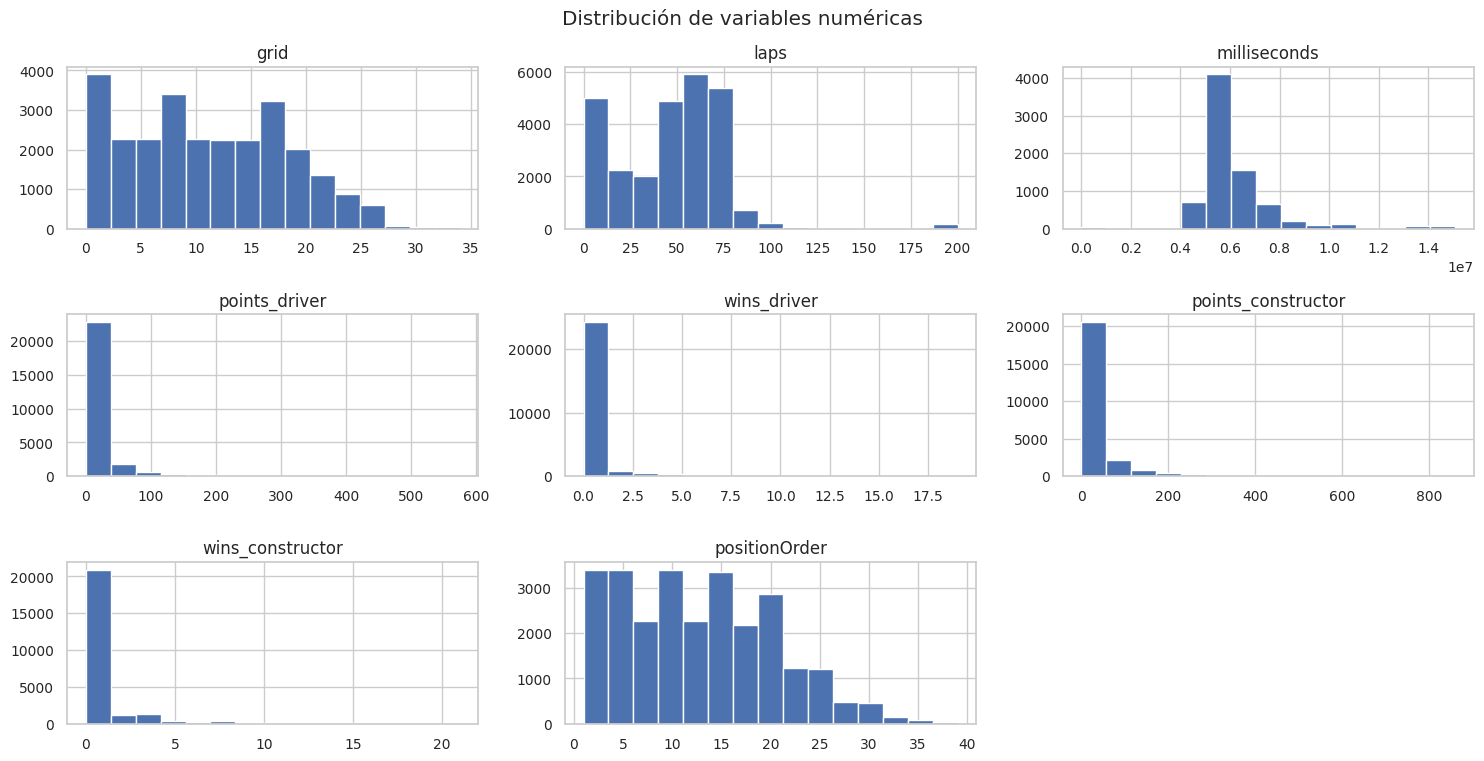

In [9]:
#Distribuciones de variables numéricas

driver_standings = driver_standings.rename(columns={'points':'points_driver','wins':'wins_driver'})
constructor_standings = constructor_standings.rename(columns={'points':'points_constructor','wins':'wins_constructor'})

merged = results.merge(races[['raceId','year','circuitId']], on='raceId', how='left')
merged = merged.merge(drivers[['driverId','forename','surname','nationality']], on='driverId', how='left')
merged = merged.merge(constructors[['constructorId','name']], on='constructorId', how='left')

merged = merged.merge(driver_standings[['raceId','driverId','points_driver','wins_driver']],
                      on=['raceId','driverId'], how='left')

merged = merged.merge(constructor_standings[['raceId','constructorId','points_constructor','wins_constructor']],
                      on=['raceId','constructorId'], how='left')



num_vars = ['grid','laps','milliseconds','points_driver','wins_driver', 'points_constructor','wins_constructor','positionOrder']
num_vars_df = merged[num_vars].copy()
num_vars_df.hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.suptitle('Distribución de variables numéricas')
plt.tight_layout()
plt.show()

#### Detección de outliers con boxplots

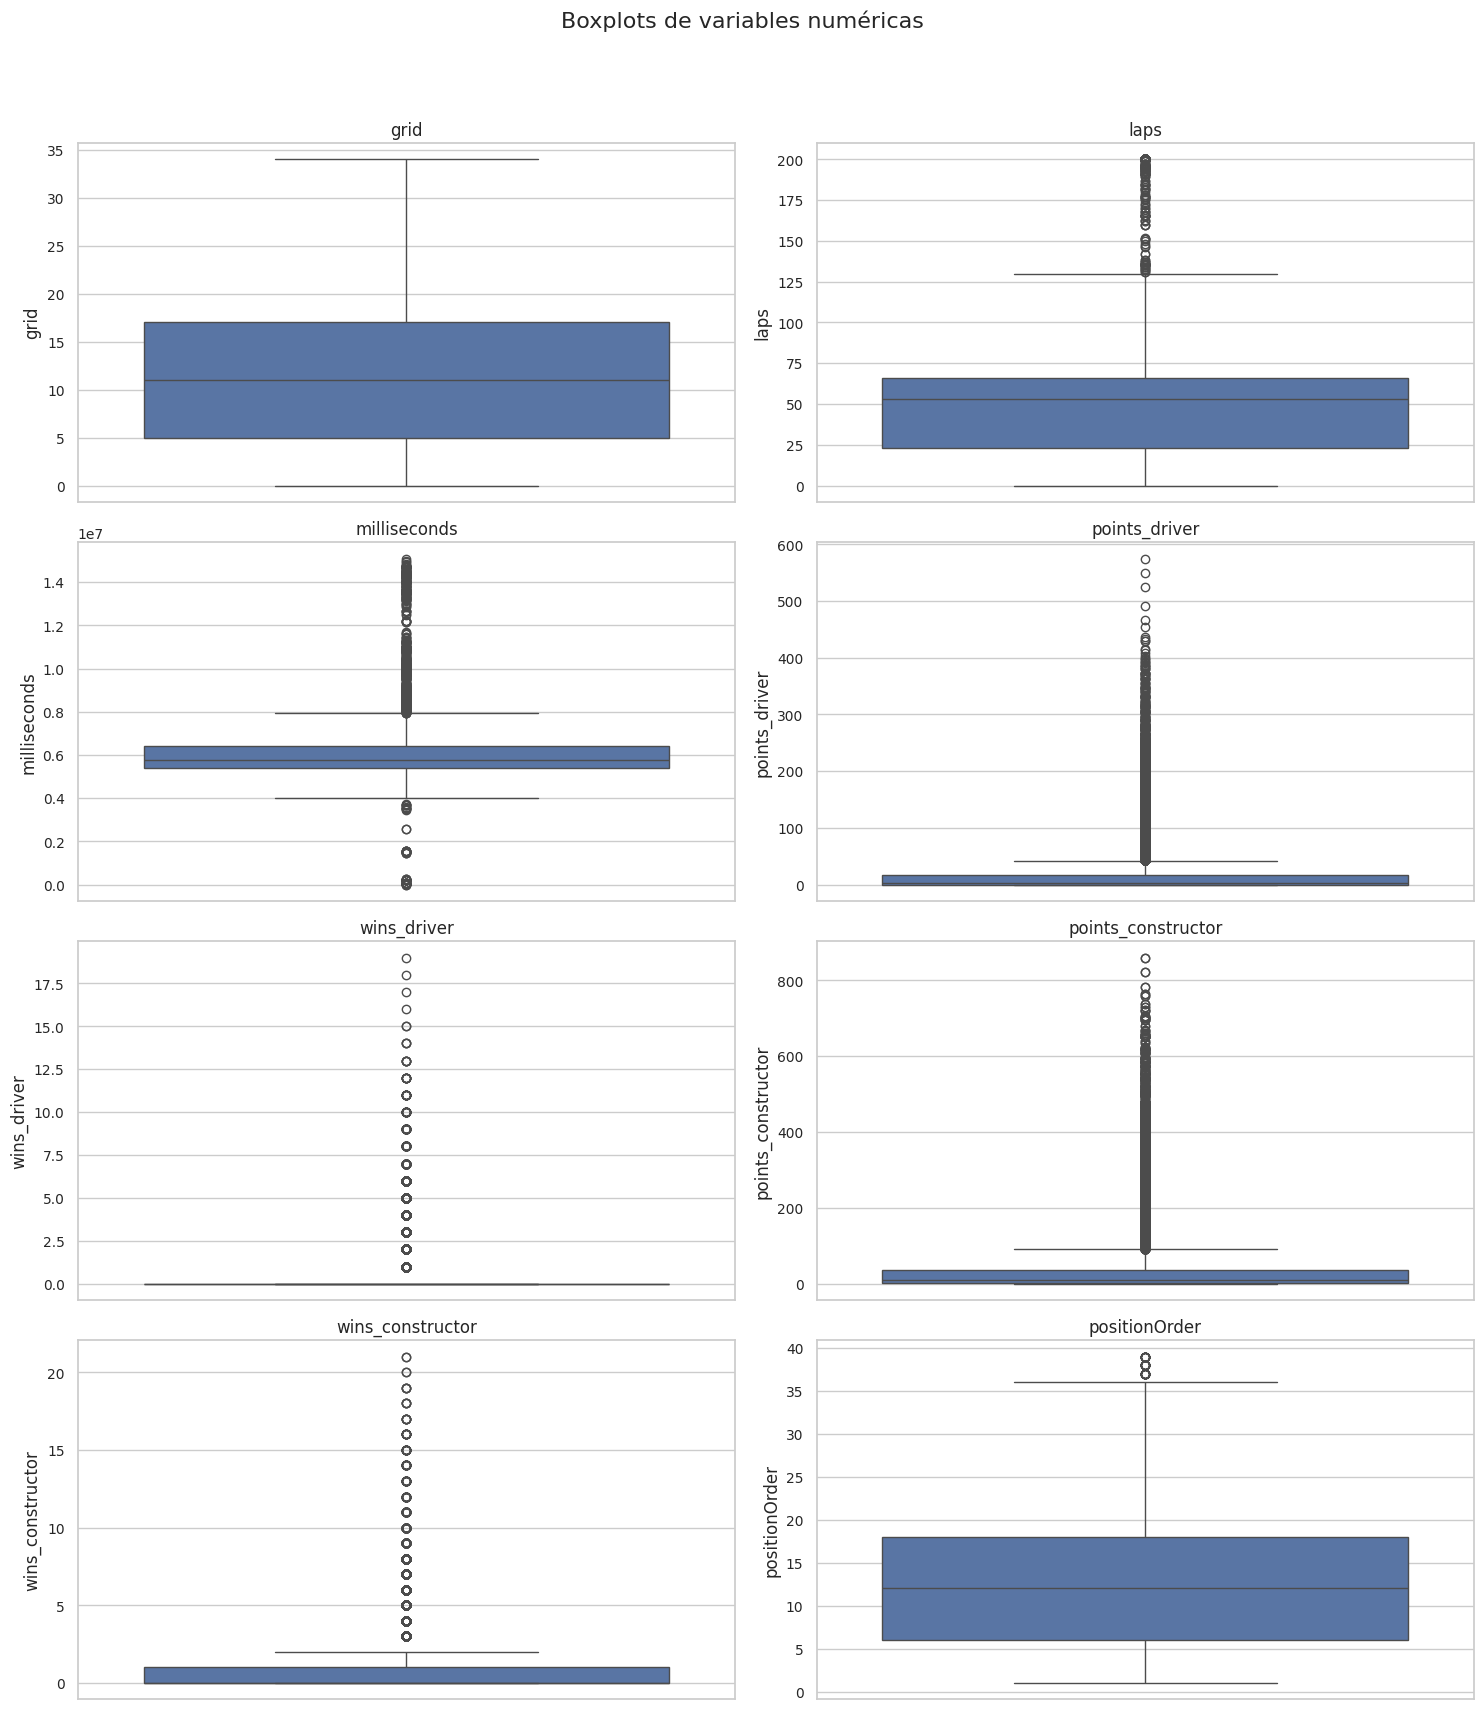

In [10]:
driver_standings = driver_standings.rename(columns={'points':'points_driver','wins':'wins_driver'})
constructor_standings = constructor_standings.rename(columns={'points':'points_constructor','wins':'wins_constructor'})

merged = results.merge(races[['raceId','year','circuitId']], on='raceId', how='left')
merged = merged.merge(drivers[['driverId','forename','surname','nationality']], on='driverId', how='left')
merged = merged.merge(constructors[['constructorId','name']], on='constructorId', how='left')

merged = merged.merge(driver_standings[['raceId','driverId','points_driver','wins_driver']],
                      on=['raceId','driverId'], how='left')

merged = merged.merge(constructor_standings[['raceId','constructorId','points_constructor','wins_constructor']],
                      on=['raceId','constructorId'], how='left')



num_vars = ['grid','laps','milliseconds','points_driver','wins_driver', 'points_constructor','wins_constructor','positionOrder']
num_vars_df = merged[num_vars].copy()

fig, axes = plt.subplots(4,2, figsize=(15, 18))

columnas = num_vars_df.select_dtypes(include='number').columns

for i, ax in enumerate(axes.flat):
    sns.boxplot(y=num_vars_df[columnas[i]], ax=ax)
    ax.set_title(columnas[i])

plt.suptitle('Boxplots de variables numéricas', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 🔗 Matriz de correlación entre variables numéricas

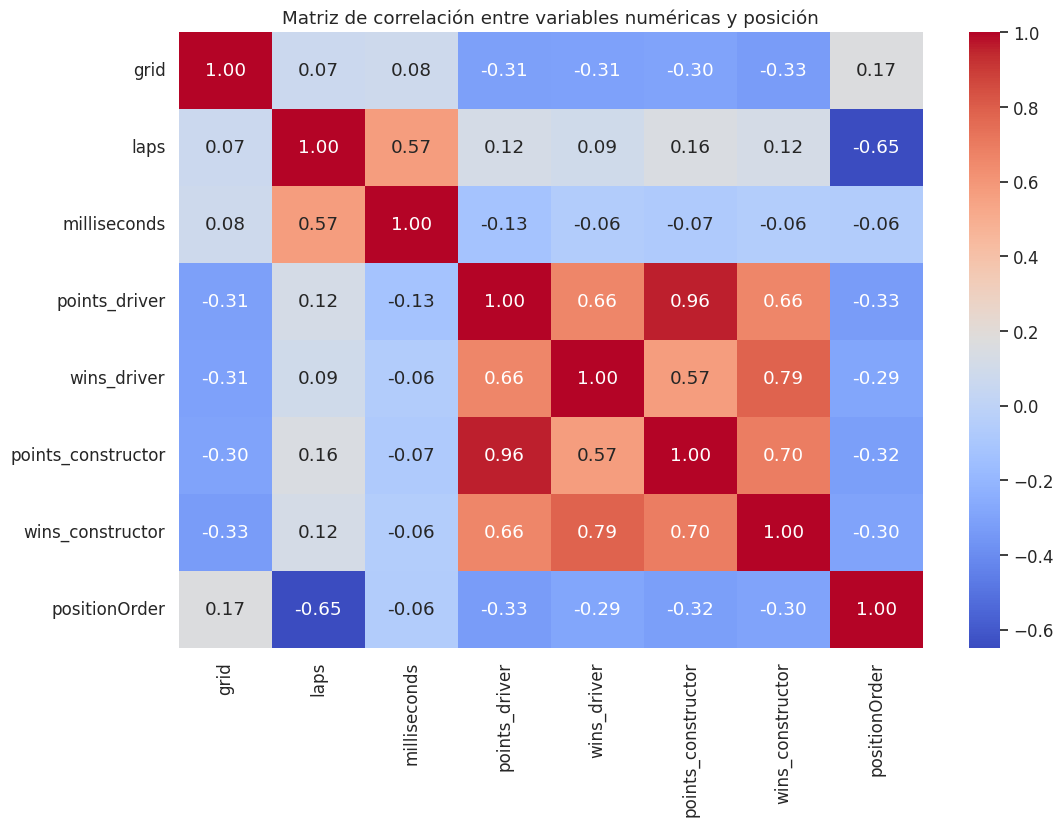

In [11]:

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12,6)


merged = results.merge(races[['raceId','year','circuitId']], on='raceId', how='left')
merged = merged.merge(drivers[['driverId','forename','surname','nationality']], on='driverId', how='left')
merged = merged.merge(constructors[['constructorId','name']], on='constructorId', how='left')

merged = merged.merge(driver_standings[['raceId','driverId','points_driver','wins_driver']],
                      on=['raceId','driverId'], how='left')

merged = merged.merge(constructor_standings[['raceId','constructorId','points_constructor','wins_constructor']],
                      on=['raceId','constructorId'], how='left')


corr_vars = ['grid','laps','milliseconds','points_driver','wins_driver', 'points_constructor','wins_constructor','positionOrder']
corr_df = merged[corr_vars].copy()


#Matriz de correlación
corr_matrix = corr_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas y posición")
plt.show()



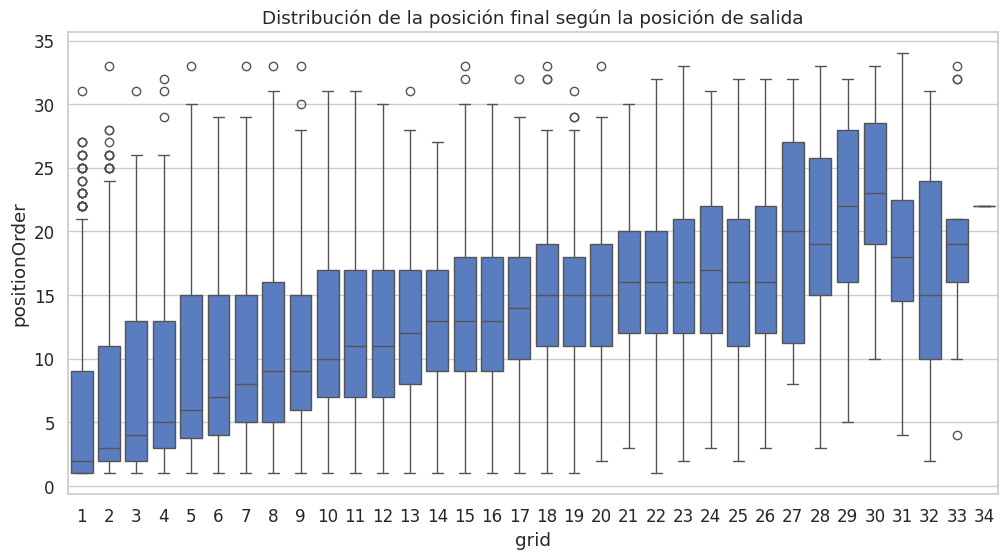

In [12]:
sns.boxplot(x='grid',y='positionOrder', data=merged[merged['grid']>0])
plt.title('Distribución de la posición final según la posición de salida')
plt.show()

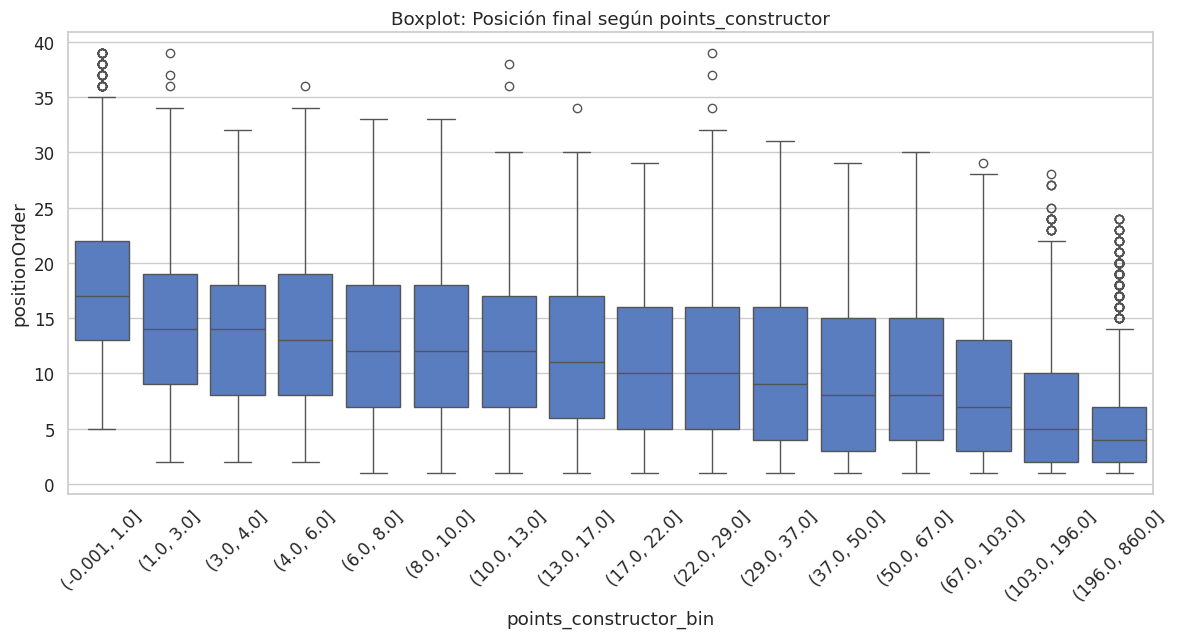

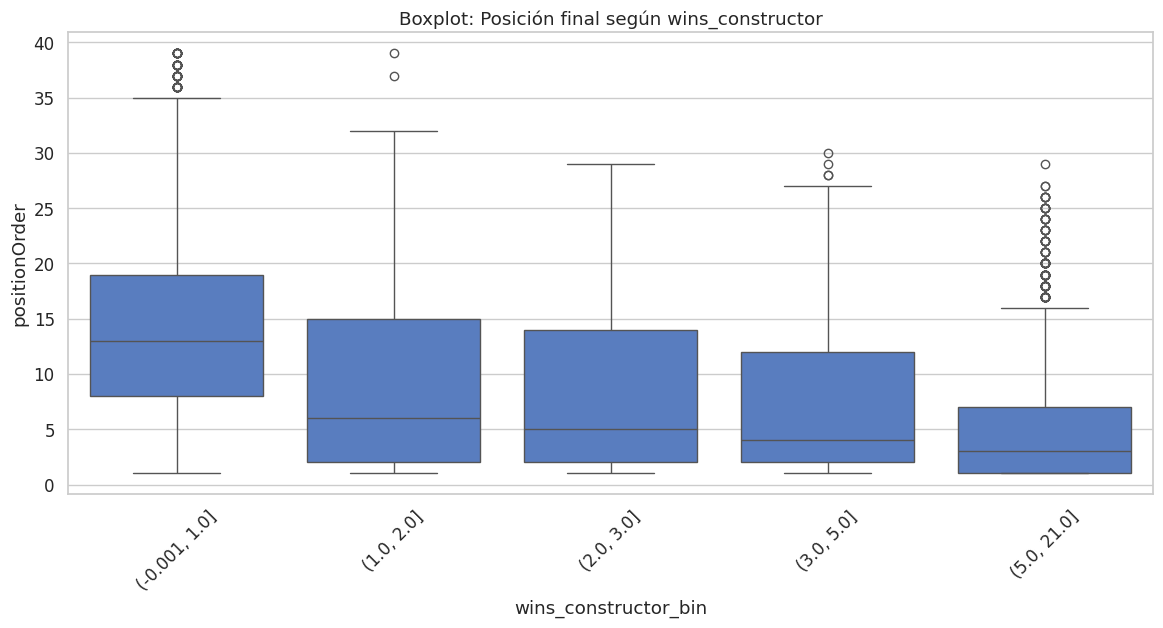

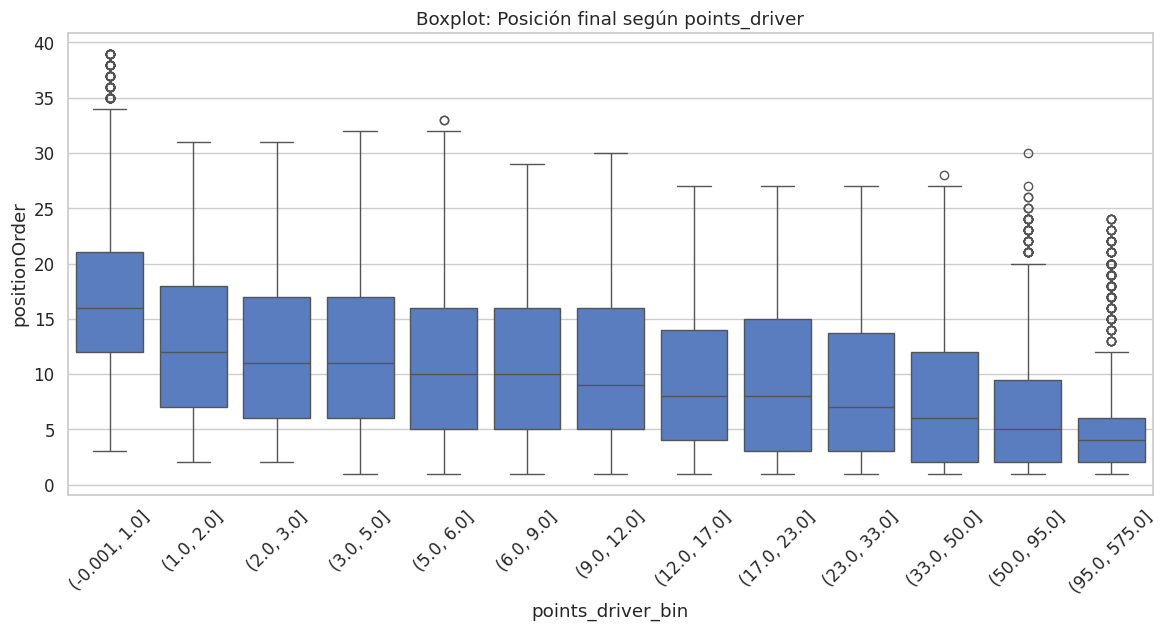

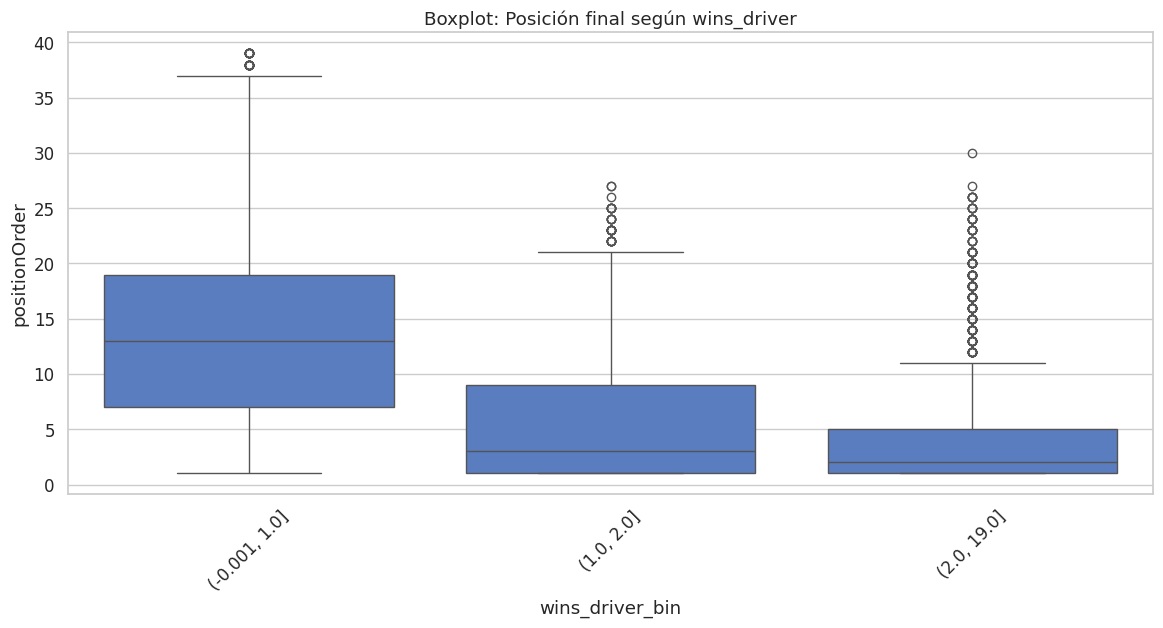

In [13]:
vars_to_plot = ['points_constructor', 'wins_constructor', 'points_driver', 'wins_driver']

for var in vars_to_plot:
    merged[f'{var}_bin'] = pd.qcut(merged[var], q=20, duplicates='drop')

    # Boxplot
    plt.figure(figsize=(14,6))
    sns.boxplot(x=f'{var}_bin', y='positionOrder', data=merged)
    plt.xticks(rotation=45)
    plt.title(f'Boxplot: Posición final según {var}')
    plt.show()


#### Comparación de resultados al correr en un circuito de su propio país a correr en un circuito extranjero

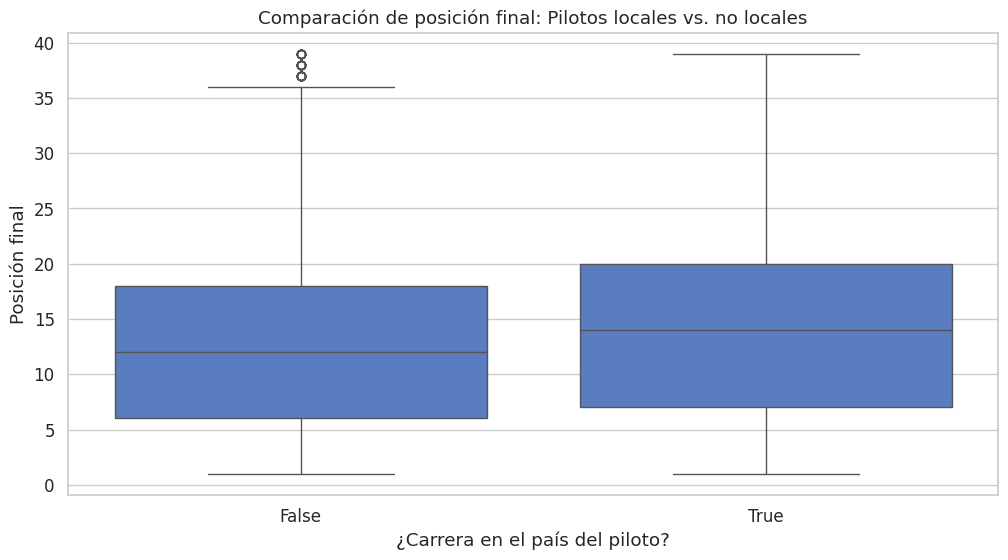

In [14]:
merged_country = merged.merge(circuits[['circuitId', 'country']], on='circuitId', how='left')

country_map = {
    'UK': 'British',
    'USA': 'American',
    'UAE': 'Emirati',
    'Russia': 'Russian',
    'Italy': 'Italian',
    'Germany': 'German',
    'France': 'French',
    'Spain': 'Spanish',
    'Brazil': 'Brazilian',
    'Japan': 'Japanese',
    'Canada': 'Canadian',
    'Australia': 'Australian',
    'Netherlands': 'Dutch',
    'Mexico': 'Mexican',
    'Finland': 'Finnish',
    'Sweden': 'Swedish',
    'Austria': 'Austrian',
    'Argentina': 'Argentine',
}

merged_country['nationality_norm'] = merged_country['nationality'].replace(country_map)
merged_country['home_race'] = (
    merged_country['country'].map(country_map).fillna(merged_country['country']) ==
    merged_country['nationality_norm']
)

home_stats = (
    merged_country.groupby('home_race')['positionOrder']
    .mean()
    .rename('avg_position')
    .reset_index()
)

sns.boxplot(x='home_race', y='positionOrder', data=merged_country)
plt.title('Comparación de posición final: Pilotos locales vs. no locales')
plt.xlabel('¿Carrera en el país del piloto?')
plt.ylabel('Posición final')
plt.show()

### 🧼 5. Diagnóstico de calidad de datos

- Si bien el dataset presenta valores nulos, estos se dan en casos esperables, tales como el valor result en una sesion siendo vacio, ya que los ultimos conductores no llegan a terminar la carrera
- Existen valores atípicos en varias variables, particularmente en el
- Se observa una posible relación positiva entre la posición inicial en la carrera (grid) y la posición final
- Se observan posibles relaciones inversas entre la posición final y los puntos y victorias previas de conductores y constructores
- No se observa una relación entre la posición y el correr una carrera en el pais propio

### 🧪 6. Transformaciones realizadas



#### Merge de tablas matcheando las claves



In [15]:
df = results.copy()

df = df.merge(
    races[['raceId', 'year', 'round', 'name', 'date', 'circuitId']],
    on='raceId',
    how='left'
)
df = df.merge(
    circuits[['circuitId', 'name', 'location', 'country', 'lat', 'lng', 'alt']],
    on='circuitId',
    how='left',
    suffixes=('', '_circuit')
)
df = df.merge(
    drivers[['driverId', 'driverRef', 'forename', 'surname', 'dob', 'nationality']],
    on='driverId',
    how='left'
)
df = df.merge(
    constructors[['constructorId', 'constructorRef', 'name', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)
df = df.merge(
    driver_standings[['raceId', 'driverId', 'points_driver', 'position', 'wins_driver']],
    on=['raceId','driverId'],
    how='left'
)

df = df.merge(
    constructor_standings[['raceId', 'constructorId', 'points_constructor', 'position', 'wins_constructor']],
    on=['raceId','constructorId'],
    how='left'
)
df = df.merge(
    qualifying[['raceId','driverId','position','q1','q2','q3']],
    on=['raceId','driverId'],
    how='left',
    suffixes=('', '_qualifying')
)

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,points_driver,position_y,wins_driver,points_constructor,position,wins_constructor,position_qualifying,q1,q2,q3
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,10.0,1.0,1.0,14.0,1.0,1.0,1.0,1:26.572,1:25.187,1:26.714
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,8.0,2.0,0.0,8.0,3.0,0.0,5.0,1:25.960,1:25.518,1:27.236
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,6.0,3.0,0.0,9.0,2.0,0.0,7.0,1:26.295,1:26.059,1:28.687
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,5.0,4.0,0.0,5.0,4.0,0.0,12.0,1:26.907,1:26.188,NaN
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,4.0,5.0,0.0,14.0,1.0,1.0,3.0,1:25.664,1:25.452,1:27.079


Crear variable categorica basada en posición

In [16]:
def classify_position(pos):
    if pos == 1:
        return 'Winner'
    elif pos in [2, 3]:
        return 'Podium'
    else:
        return 'No Podium'

df['position_category'] = df['positionOrder'].apply(classify_position)

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,position_y,wins_driver,points_constructor,position,wins_constructor,position_qualifying,q1,q2,q3,position_category
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,1.0,1.0,14.0,1.0,1.0,1.0,1:26.572,1:25.187,1:26.714,Winner
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,2.0,0.0,8.0,3.0,0.0,5.0,1:25.960,1:25.518,1:27.236,Podium
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,3.0,0.0,9.0,2.0,0.0,7.0,1:26.295,1:26.059,1:28.687,Podium
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,4.0,0.0,5.0,4.0,0.0,12.0,1:26.907,1:26.188,NaN,No Podium
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,5.0,0.0,14.0,1.0,1.0,3.0,1:25.664,1:25.452,1:27.079,No Podium


#### Complementación del dataset con datos climaticos para carreras recientes utilizando la api de FastF1 y relleno con mediana para carreras viejas sin datos climaticos



In [17]:
import fastf1
os.makedirs("cache", exist_ok=True)
fastf1.Cache.enable_cache("cache")

#Para evitar tener que volver a cargar todo desde la API (es lento, incluso con cache, y probablemente cause un rate limit), guardamos el dataset de clima en un archivo aparte
climate_csv = 'climate_data.csv'
if os.path.exists(climate_csv):
    climate_df = pd.read_csv(climate_csv)
else:
    climate_df = pd.DataFrame(columns=['raceId','year','name','AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed'])


# Solo considerar carreras modernas (FastF1)
modern_races = df[df['year']>=2018][['raceId','year','name']].drop_duplicates()

for _, race in modern_races.iterrows():
    race_id = race['raceId']
    if race_id in climate_df['raceId'].values:
        continue

    try:
        session = fastf1.get_session(race['year'], race['name'], 'R')
        session.load()


        weather_avg = session.weather_data[['AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']].mean()

        new_row = {
            'raceId': race_id,
            'year': race['year'],
            'name': race['name'],
            'AirTemp': weather_avg['AirTemp'],
            'TrackTemp': weather_avg['TrackTemp'],
            'Humidity': weather_avg['Humidity'],
            'Rainfall': weather_avg['Rainfall'],
            'WindSpeed': weather_avg['WindSpeed']
        }
        climate_df = pd.concat([climate_df, pd.DataFrame([new_row])], ignore_index=True)

    except Exception as e:
        pass


climate_df.to_csv(climate_csv, index=False)


climate_cols = ['AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']
df = df.drop(columns=[c for c in climate_cols if c in df.columns])

df = df.merge(climate_df[['raceId','AirTemp','TrackTemp','Humidity','Rainfall','WindSpeed']],
              on='raceId', how='left')


for col in climate_cols:
    df[col] = df[col].fillna(df[col].median())

df.head()

events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '43'
core        WARNING 	Fixed

,resultId,raceId,driverId,constructorId,number,grid,position_x,positionText,positionOrder,points,...,position_qualifying,q1,q2,q3,position_category,AirTemp,TrackTemp,Humidity,Rainfall,WindSpeed
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,1.0,1:26.572,1:25.187,1:26.714,Winner,23.176087,35.523529,54.157658,0.0,1.520979
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,5.0,1:25.960,1:25.518,1:27.236,Podium,23.176087,35.523529,54.157658,0.0,1.520979
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,7.0,1:26.295,1:26.059,1:28.687,Podium,23.176087,35.523529,54.157658,0.0,1.520979
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,12.0,1:26.907,1:26.188,NaN,No Podium,23.176087,35.523529,54.157658,0.0,1.520979
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,3.0,1:25.664,1:25.452,1:27.079,No Podium,23.176087,35.523529,54.157658,0.0,1.520979


### ✍️ 7. Reflexión final

En cuanto a transformaciones del dataset, primero decidimos juntar nuestras distintas fuentes de datos mediante un merge, para facilitar el acceso y comparación de información como una unica tabla. Luego, para permitir futuros analisis supervisados, se convirtió la posición en una variable categorica que clasifica de forma que nos sea relevante para nuestros resultados esperados.

Además, para poder obtener una mayor cantidad de datos que puedan sernos relevantes para el analisis, se complementó el dataset con informacíón de otra fuente: la api de FastF1, la cual cuenta con informacíón sobre el clima que se tuvo durante la carrera. Esta api cuenta con el problema de tener una cantidad de carreras más acotada que el dataset base que usamos, por lo que decidimos llenar la información del clima que quedó vacía para las carreras más viejas con la mediana de los climas obtenidos por la API, en un intento de simular un dia con clima "normal".

Ya habiendo analizado el dataset, consideramos que para la siguiente etapa sería más conveniente priorizar las características de los equipos que participan en Fórmula 1 con las regulaciones más recientes (los cambios más importantes de regulaciones de parte de la FIA afectan al diseño de los autos, las estrategias y el dominio de los equipos). Considerando que en este dataset ya transformado se tienen fundamentalmente datos históricos vinculados a las posiciones y el mejor tiempo obtenido en clasificación y carrera entendemos que parte de las variables que afectan al momento de correrse un Grand Prix más allá del clima no se tienen en cuenta como los tiempos de pitstop (que afectan especialmente para equipos que tienen un rendimiento similar), la estrategia de carrera (cuantas paradas y con que compuestos), ritmo de carrera para cada compuesto (en base a los tiempos de vuelta obtenidos en las prácticas libres) y otras variables que pueden afectar al comportamiento de los pilotos más allá de los puntos en el campeonato, como puede ser si se perdieron alguna sesión de prácticas libres, si es la primera vez corriendo en un circuito o si sufrió accidentes en sesiones previas a la carrera (no siempre se logra tener el auto en las mismas condiciones de prácticas sin recibir una penalidad en la grilla de partida). Por lo tanto, nuestra postura inicial es primero analizar de que manera se comporta el modelo para predecir las posiciones de los pilotos para un circuito en particular dadas las condiciones climáticas del dia de la carrera y el resultado en clasificación para luego empezar a experimentar con otras de las variables mencionadas, si es que notamos que son necesarias para aumentar la precisión de nuestro modelo. Para este último caso se considera la API de FastF1 como posible fuente para la información de pitstops y los ritmos de carrera según los compuestos usados.